# About MNIST Dataset
- MNIST is a dataset consisting of 70000 black-and-white images of handwritten digits.
- Each image has `28 x 28` pixels.
- There are a total of 10 classes (0 to 9).
- Each pixel is encoded as an integer from 0 to 255. Lower pixel values represent darker colors (black) and higher pixel values represent light colors (white).
- 60000 images are used as a part of training and 10000 images are used as a part of testing.

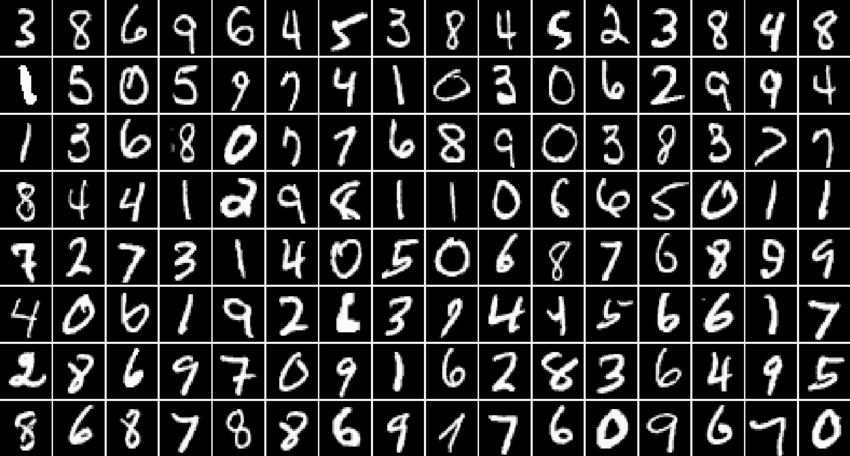

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

In [2]:
pd.set_option("display.max_columns", None)
sns.set_theme(style = "whitegrid")
warnings.filterwarnings("ignore")

# Overview Of CNN Model

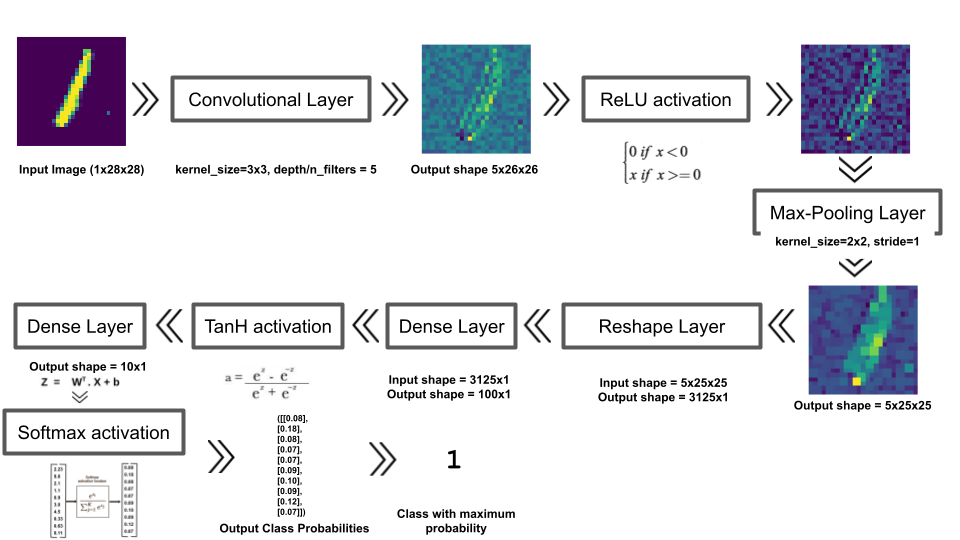

A base `Layer` class is defined to specify the default layer properties that will be inherited by the `Convolutional`, `Activation`, `MaxPool`, `Reshape`, `Dense` classes. All of these classes are derived classes of the `Layer` class.

The `Layer` class has 2 attributes,
- `forward`: Takes in the input to the layer and returns the output via the specified calculation for each layer.
- `backward`: Takes in the output gradient to update the layer's parameters and return the input gradient.

In [3]:
# defining the Layer class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
    
    def forward(self, input):
        # return output
        pass

    def backward(self, output_gradient, learning_rate):
        # update parameters and return input gradient
        pass

Forward propagation is simply feeding the data in the forward direction to the model. In this case the model is a Neural Network and each of the training images is processed through the `Convolutional`, `Activation`, `MaxPool`, `Reshape`, `Dense` layers

# `Convolutional` Layer
The `Convolutional` class inherits from the `Layer` class and takes input parameters,
- Input shape.
- Kernel size.
- Depth or Number of Kernels or Filters for the layer.

Defining and initializing the input and output shapes of input image, kernel size and bias.

In [4]:
class Convolutional(Layer):
    def __init__(self, input_shape, kernel_size, depth):
        # input_shape is 3 dimensional (d x h x w), 
        # input_depth = number of image input channels, input_height = image height and input_width = image width
        input_depth, input_height, input_width = input_shape

        self.input_shape = input_shape

        # depth = number of kernels in the convolutional layer
        self.depth = depth
        
        # number of channels in the image are 3 for a RGB image and 2 for a grayscale image
        self.input_depth = input_depth

        # calculating the convolutional layer output of 3 dimensions
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)

        # kernel_shape specifies the shape of the Kernel produced
        # it has 4 dimensions, depth = number of Kernels (depth), input_shape = image channels, kernel_size = kernel dimension
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)

        # randomly initializing the Kernel weights
        self.kernels = np.random.randn(*self.kernels_shape)

        # randomly initializing the biases
        self.biases = np.random.rand(*self.output_shape)

    def forward(self, input):
        pass

    def backward(self, output_gradient, learning_rate):
        pass

After taking these parameters, the `Convolutional` layer processes the inputs through the forward and backward functions during model training.

### Forward propagation in `Convolutional` layer
- During the forward propagation, the `Convolutional` layer iterates through each filter, applying it to every possible location within the input image channels. At each location, the filter is convolved with the corresponding region of the input, producing a scalar value that represents the filter's response at thet position. This process generates a set of feature maps, each representing the activation of a specific filter across the entire input image.

    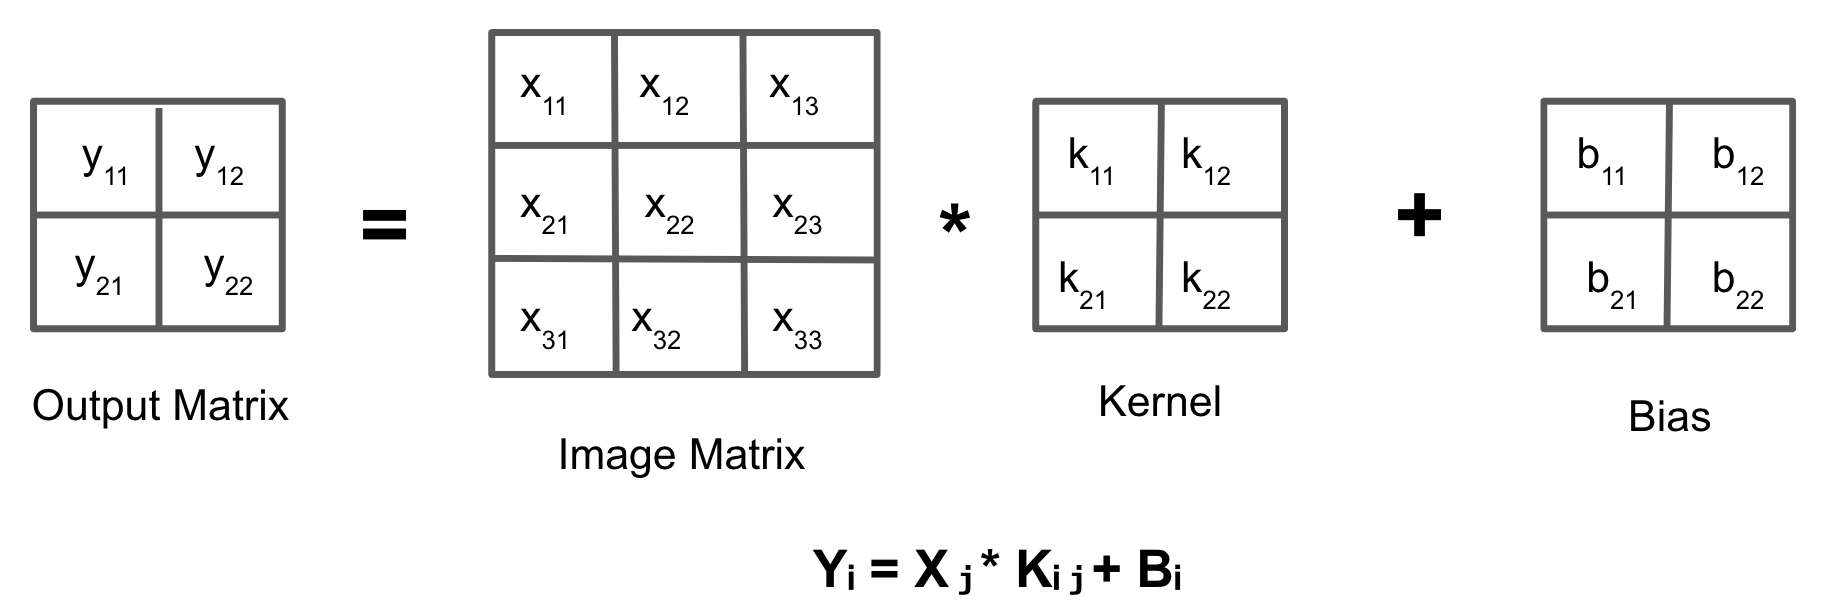

- Forward propagation for `Convolutional` layer is mathematically expressed as, $Y_i = \sum_{j = 1}^n X_j * K_{ij} + B_i$. Where, i = 1, ...., depth. Where,
    - Y is the output of the convolutional operation which is equal to the sum of bias and sum of cross-correlations between the input image ($X_j$) and the `Convolutional` Kernel ($k_{ij}$).
- This equation is intended to represent the output calculation for each filter within the `Convolutional` layer, iterating through all filters (depth) to produce a set of feature maps and each resulting from the application of a specific filter to the entire input image.
- The following is obtained after expanding the above equation,

    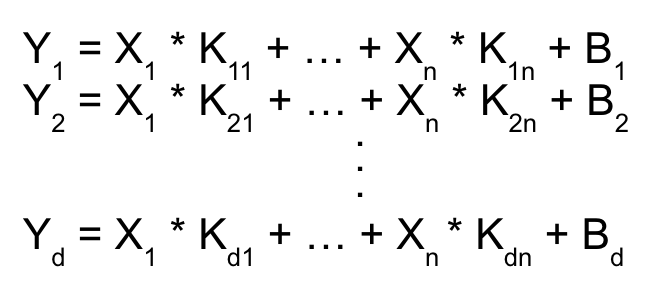

    Where, d = depth or number of filters, n = input depth.
- By using these equations, the filters are passed with their weights over the image matrix, to compute the output of the convolutional layer.

In [5]:
# the convolution operation is performed using correlate2d() method of scipy package
from scipy import signal

class Convolutional(Layer):

    def __init__(self, input_shape, kernel_size, depth):
        # input_shape is 3 dimensional (d x h x w), 
        # input_depth = number of image input channels, input_height = image height and input_width = image width
        input_depth, input_height, input_width = input_shape

        self.input_shape = input_shape

        # depth = number of kernels in the convolutional layer
        self.depth = depth
        
        # number of channels in the image are 3 for a RGB image and 2 for a grayscale image
        self.input_depth = input_depth

        # calculating the convolutional layer output of 3 dimensions
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)

        # kernel_shape specifies the shape of the Kernel produced
        # it has 4 dimensions, depth = number of Kernels (depth), input_shape = image channels, kernel_size = kernel dimension
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)

        # randomly initializing the Kernel weights
        self.kernels = np.random.randn(*self.kernels_shape)

        # randomly initializing the biases
        self.biases = np.random.rand(*self.output_shape)

    # forward pass takes input and computes the output by applying the above convolution
    def forward(self, input):
        self.input = input

        # initialize the output matix with output_shape
        self.output = np.zeros(self.output_shape)

        # 2 nested for loops, first one to traverse all the Filters (depth), second one to traverse all the channels (input_depth) in every input image
        for i in range(self.depth):
            for j in range(self.input_depth):

                # output is calculated by adding the biases of the layer with the cross correlation between image and the Kernel, "valid" stands for no padding.
                self.output[i] += self.biases[i] + signal.correlate2d(self.input[j], self.kernels[i, j], "valid")

        return self.output
    
    def backward(self, output_gradient, learning_rate):
        pass

### Back propagation in `Convolutional` layer
Back propagation or backward propagation refers to updating the weights and biases of the model with respect to the loss of the model.

In case of convolution,
- The parameters that are to be updated are, Kernels, inputs and biases.
- For updating the Kernels and biases their gradients have to be computed.

From the forward propagation, the derivative of the error is obtained, from this, the following will be computed,
- Derivative of $L$ (Loss) (error of the network) with respect to the Kernels ($K$) and biases of the layer ($B$).
- Derivative of $L$ with respect to the input ($X$).

    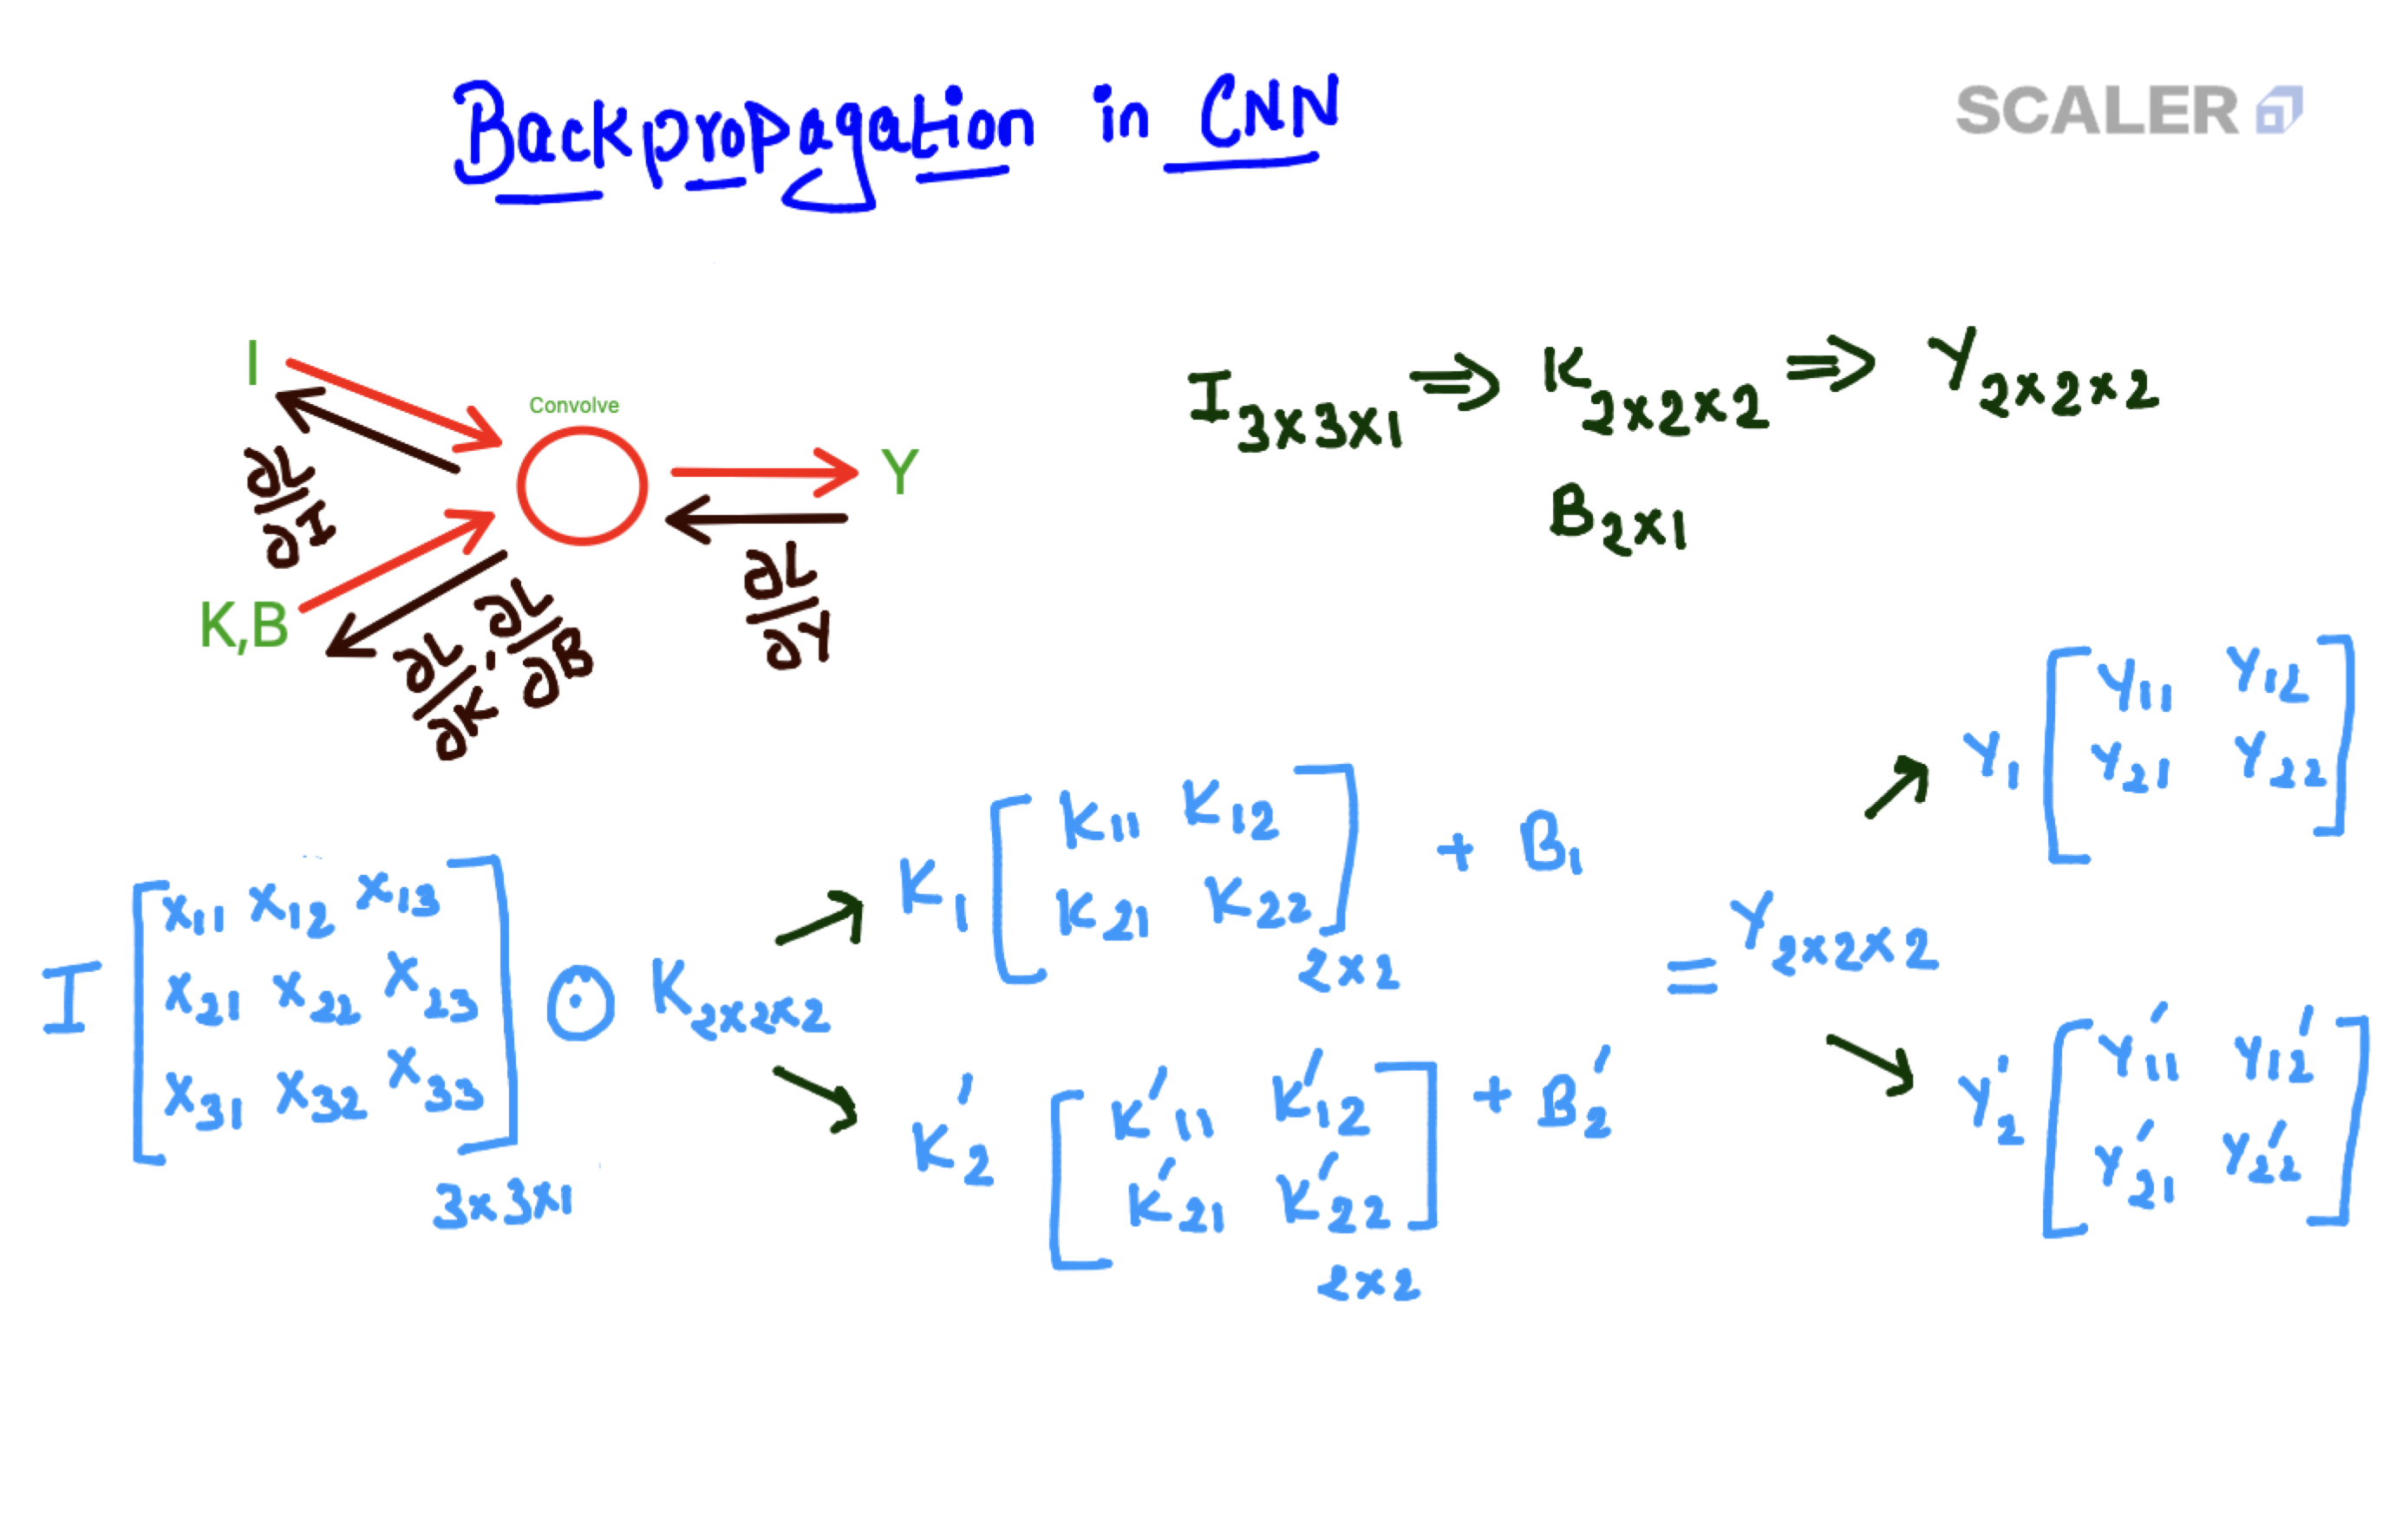

1. Kernel updates: The image below depicts the computations of the derivative of the Loss ($L$) with respect to the Kernels ($K$).

    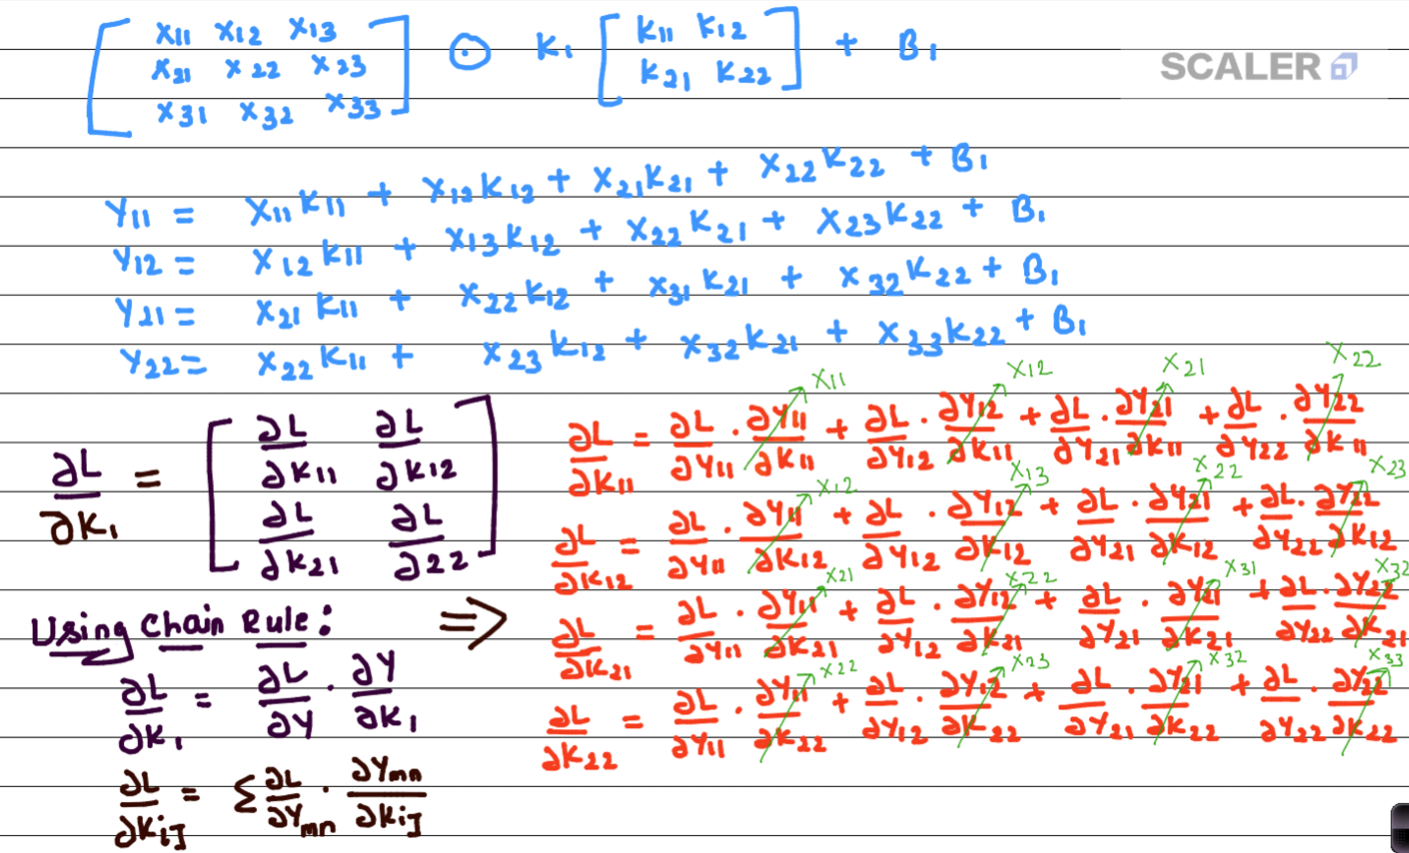

    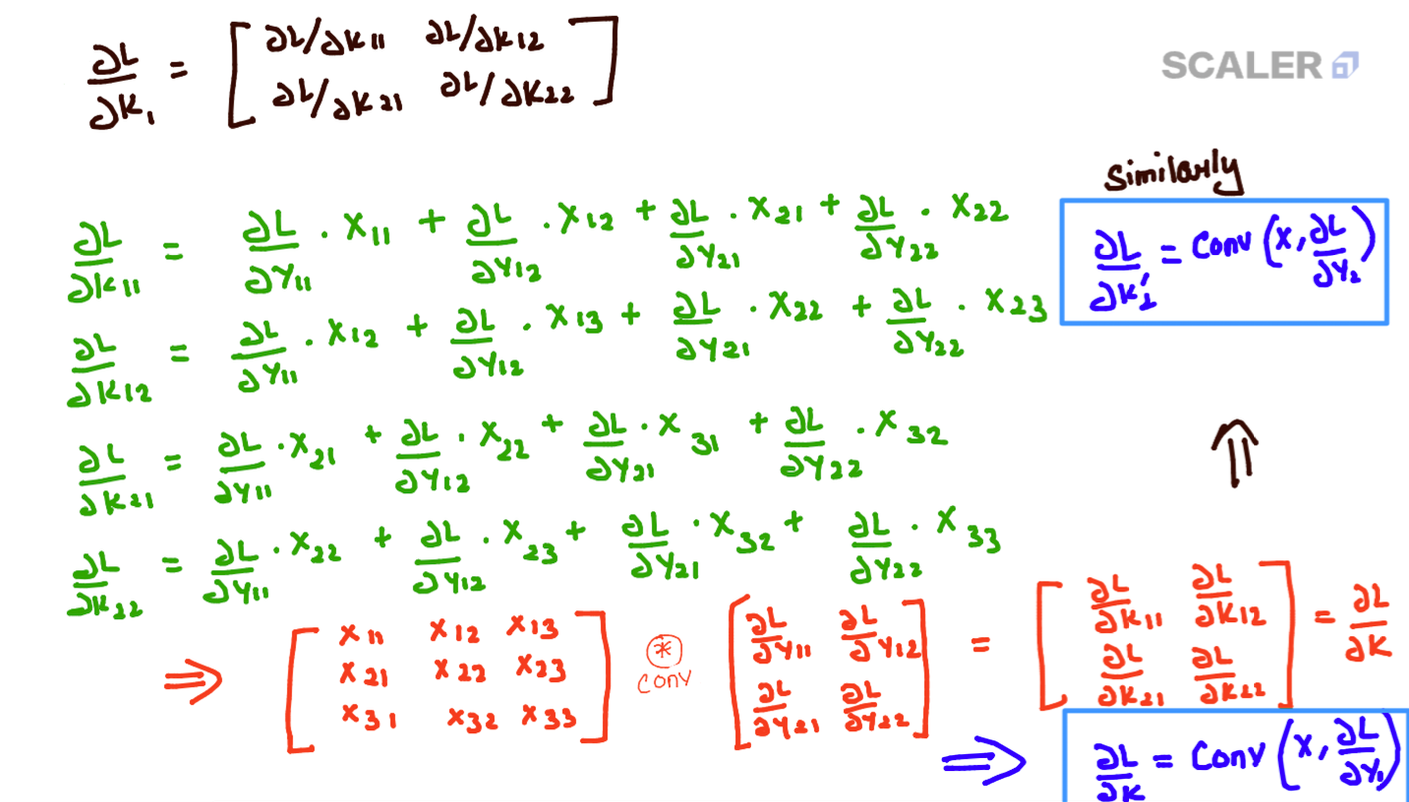

2. Bias updates: Then the derivative of $L$ (error of the network) with respect to the bias of the layer is calculated as follows,

    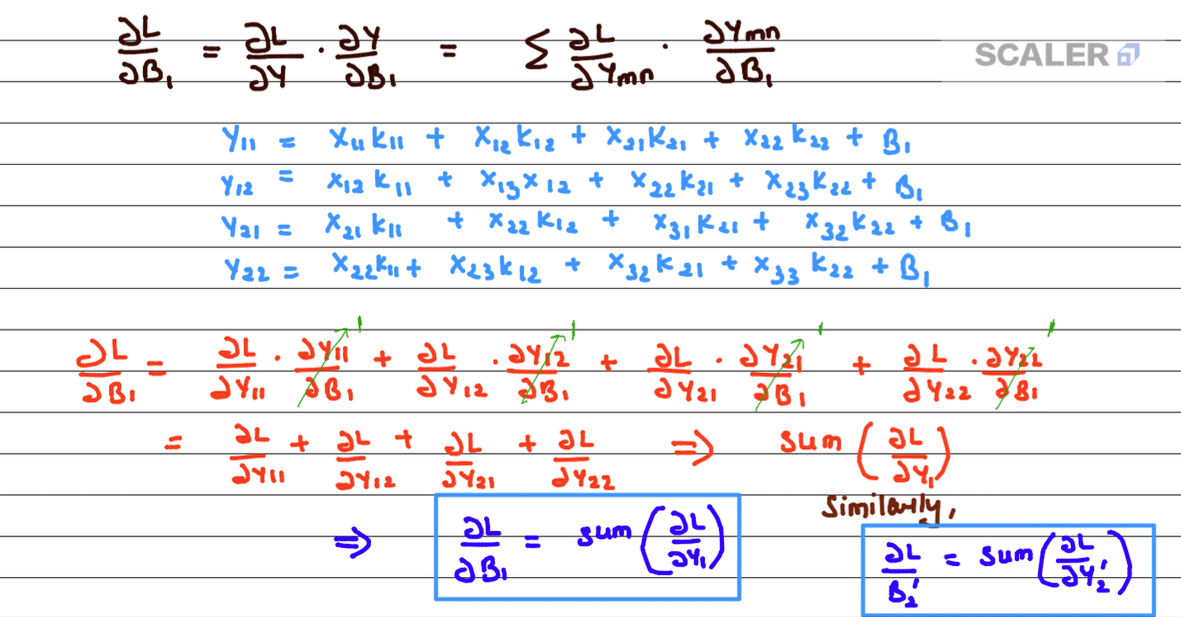

3. Input updates: The derivative of $L$ with respect to the input of the layer is calculated as follows,

    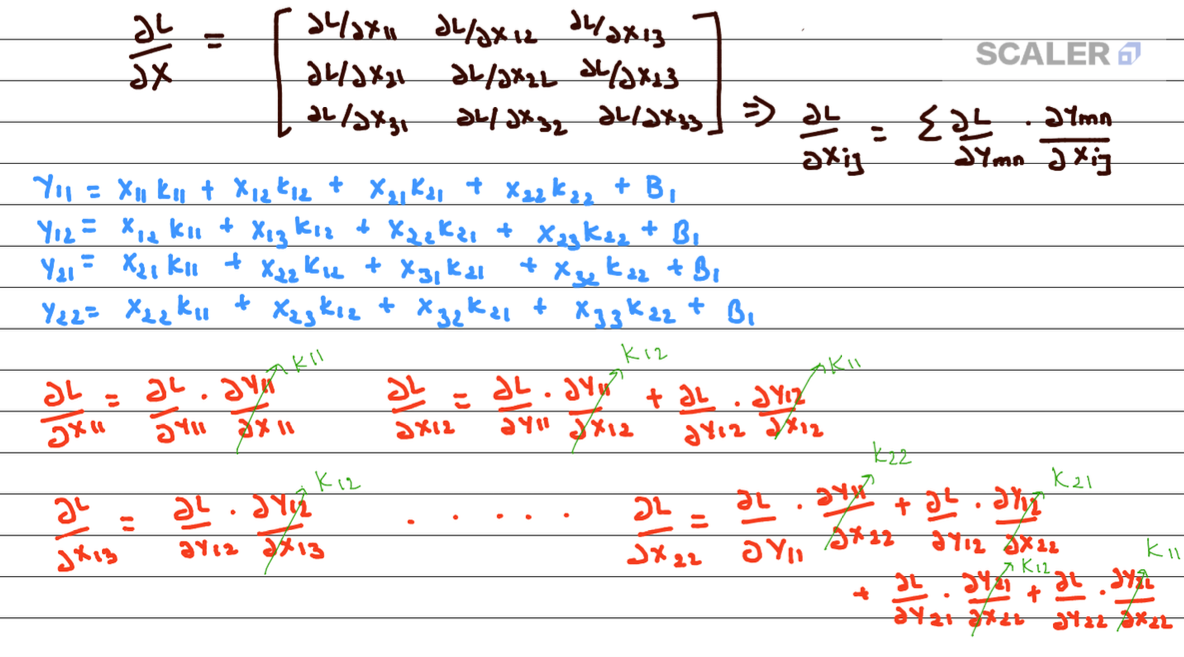

    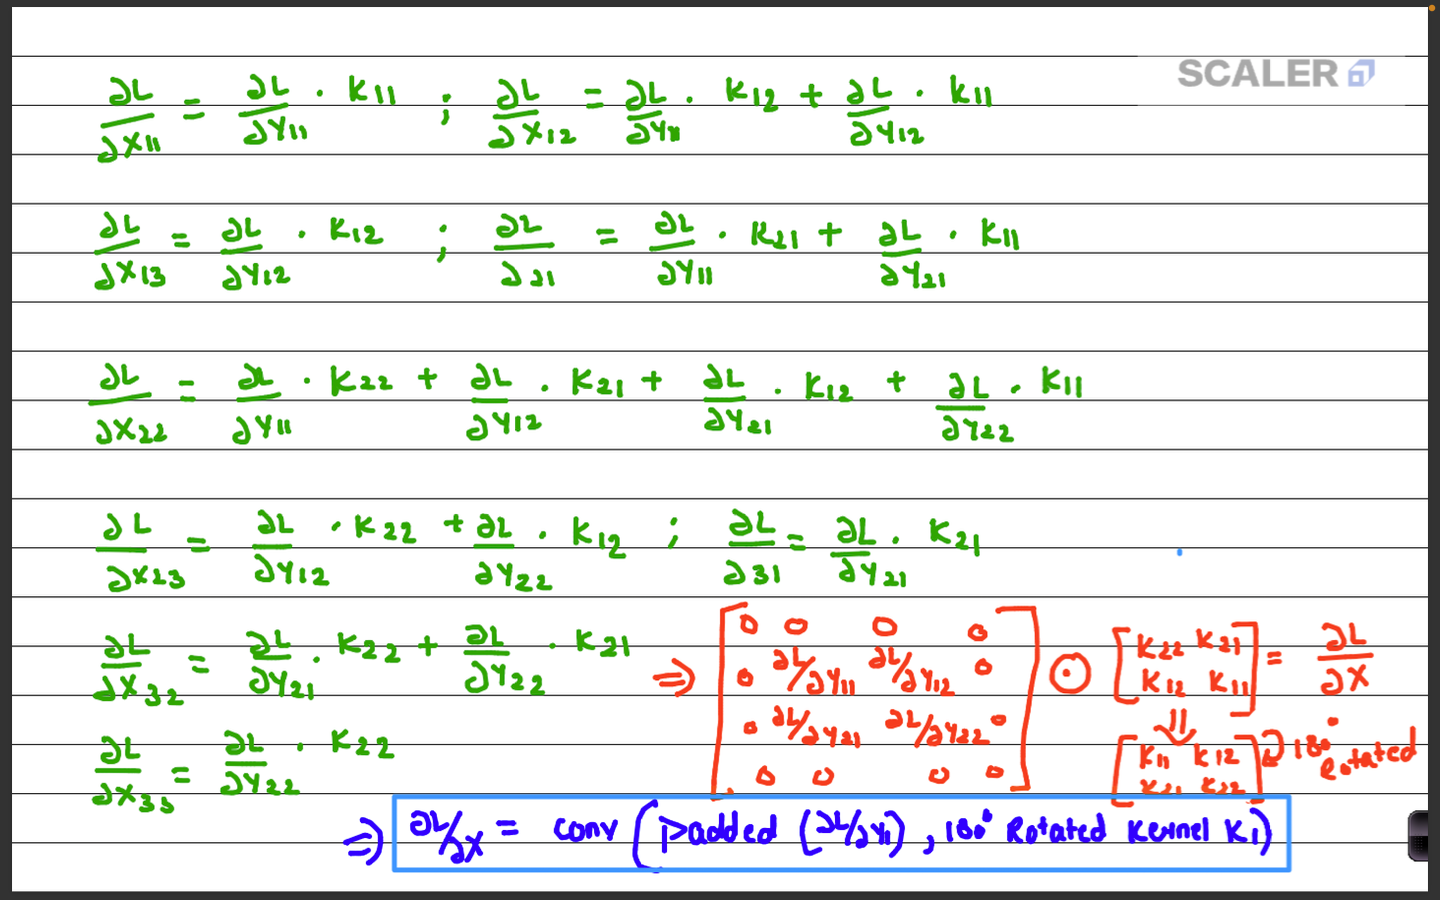

The following is how the above works,

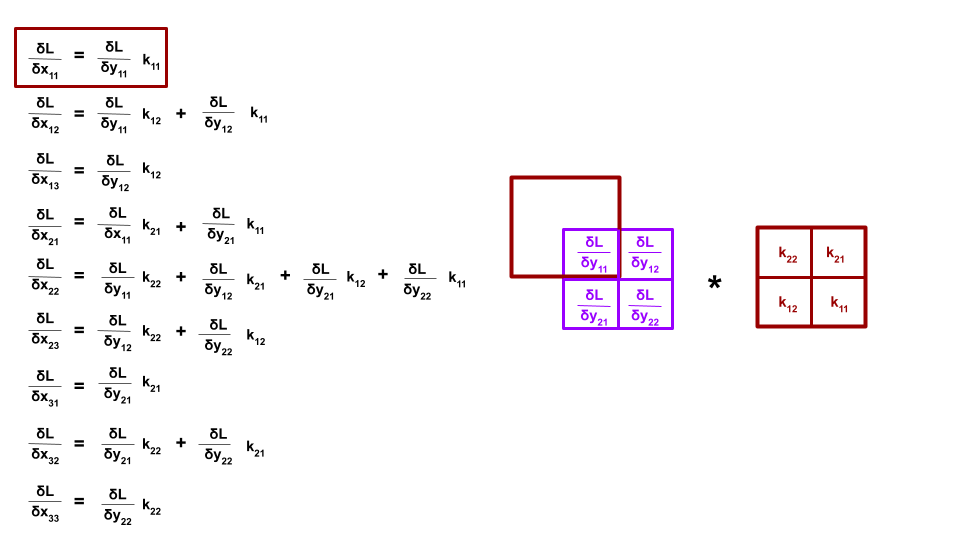

The above depicts that the input gradient i.e., derivative of Loss with respect to the input is equal to the output gradient i.e., derivative of Loss with respect to the output gradient fully cross-correlated ("*" symbol) with 180 degrees rotated Kernel.

Put simply, the input gradient, which shows how much the loss function changes with respect to the input, can be calculated by taking the output gradient (how much the loss changes with respect to the output) and performing a specific type of operation called a "fully cross-correlated" with the kernel. This kernel is flipped 180 degrees before the operation.

In [6]:
# the convolution operation is performed using correlate2d() method of scipy package
from scipy import signal

class Convolutional(Layer):

    def __init__(self, input_shape, kernel_size, depth):
        # input_shape is 3 dimensional (d x h x w), 
        # input_depth = number of image input channels, input_height = image height and input_width = image width
        input_depth, input_height, input_width = input_shape

        self.input_shape = input_shape

        # depth = number of kernels in the convolutional layer
        self.depth = depth
        
        # number of channels in the image are 3 for a RGB image and 2 for a grayscale image
        self.input_depth = input_depth

        # calculating the convolutional layer output of 3 dimensions
        self.output_shape = (depth, input_height - kernel_size + 1, input_width - kernel_size + 1)

        # kernel_shape specifies the shape of the Kernel produced
        # it has 4 dimensions, depth = number of Kernels (depth), input_shape = image channels, kernel_size = kernel dimension
        self.kernels_shape = (depth, input_depth, kernel_size, kernel_size)

        # randomly initializing the Kernel weights
        self.kernels = np.random.randn(*self.kernels_shape)

        # randomly initializing the biases
        self.biases = np.random.rand(*self.output_shape)

    # forward pass takes input and computes the output by applying the above convolution
    def forward(self, input):
        self.input = input

        # initialize the output matix with output_shape
        self.output = np.zeros(self.output_shape)

        # 2 nested for loops, first one to traverse all the Filters (depth), second one to traverse all the channels (input_depth) in every input image
        for i in range(self.depth):
            for j in range(self.input_depth):

                # output is calculated by adding the biases of the layer with the cross correlation between image and the Kernel, "valid" stands for no padding.
                self.output[i] += self.biases[i] + signal.correlate2d(self.input[j], self.kernels[i, j], "valid")

        return self.output
    
    def backward(self, output_gradient, learning_rate):
        # initialize the gradient of the Kernels as 0
        kernel_gradient = np.zeros(self.kernels_shape)
        # initialize the gradient of the inputs as 0
        input_gradient = np.zeros(self.input_shape)

        # the following nested for loops update the gradients
        # first all the Filters (depth) are traversed
        # then all the channels in every input image (input_depth) are traversed
        # this is done to update the gradients of Kernels and inputs
        for i in range(self.depth):
            for j in range(self.input_depth):

                # the following code line calculates Kernel gradient in every i and j index in the Kernel by computing the correlation between image and output gradient
                kernel_gradient[i, j] = signal.correlate2d(self.input[j], output_gradient[i], "valid")
                # the following code line calculates input gradient by sliding the Kernel on the output gradient matrix
                input_gradient[j] += signal.convolve2d(output_gradient[i], self.kernels[i, j], "full")

        # update the Kernels and biases with respect to learned features (stored in gradients)
        # gradients are multiplied with the learning rate to update the Kernels and biases
        self.kernels -= learning_rate * kernel_gradient
        self.biases -= learning_rate * np.sum(output_gradient)

        return input_gradient

# `Activation` Layer
3 activation function were majorly used in the CNN model architecture, which are ReLU, TanH and Softmax.

During back propagation, the gradient calculation for each activation function involves applying its respective derivative to the input.

Specifically, the gradients from the preceeding layer are multiplied by the input values that were passes through the activation function.

In [7]:
# base Activation class to specify the default properties of the Activation layer from which all the activation functions are derived
class Activation(Layer):
    
    def __init__(self, activation, activation_prime):

        # calculation for the activation function
        self.activation = activation
        # calculation for derivative of the activation function which will be handy while backpropagation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(self.input)
    
    def backward(self, output_gradient, learning_rate):
        # multiplying the output gradient and the derivative of the loss to impleent the backward function for the activation
        return np.multiply(output_gradient, self.activation_prime(self.input))

### ReLU
The ReLU activation function works on the following principle,
- If the input value is less than 0, the output is 0.
- Else if the input value is greater than or equal to 0, the output is the same as the input.

ReLU introduces non-linearity into the CNN, preventing over-reliance on certain features. This is achieved by non-linearly dropping Neurons, effectively introducing sparsity into the network's activations.

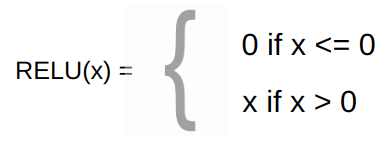

During back propagation, ReLU activation works as follows,

For $x > 0$ the output is $x$, i.e. $f(x) = max(0, x)$

Derivative of $f(x)$ = $f'(x)$ : if $x < 0$, output is $0$. if $x > 0$, output is 1.

The derivative $f'(0)$ is not defined. So it's usually set to $0$.

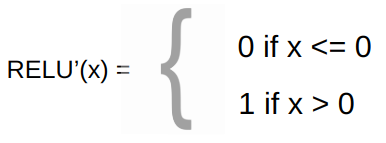

Python code for the above,

```Python
def relu_prime(x):
    return np.where(x <= 0, 0, 1)
```

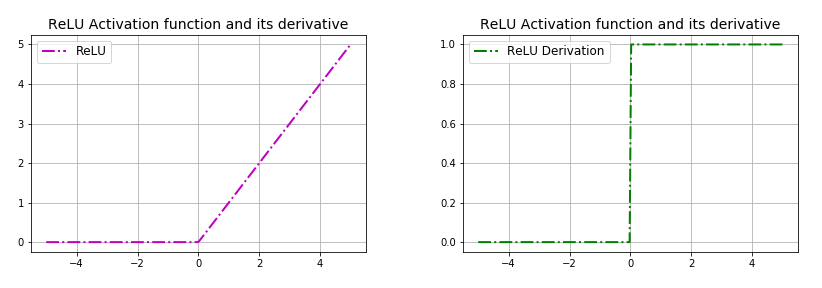

In [8]:
class ReLU(Activation):
    def __init__(self):
        def relu(x):
            return np.where(x > 0, x, 0)
        
        def relu_prime(x):
            return np.where(x <= 0, 0, 1)
        
        super().__init__(relu, relu_prime)

### TanH
The TanH activation function takes any input value and outputs the value in the range -1 to 1.
- Larger the input value, the output value will be closer to 1.
- Smaller the input value, the output value will be closer to -1.

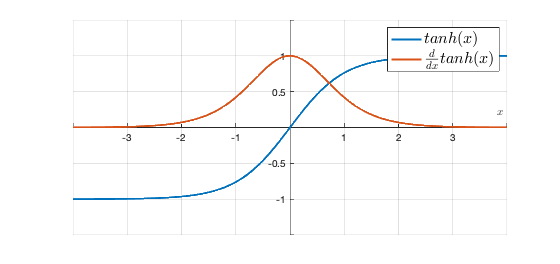

In practice, the TanH activation function is often preferred when aiming for faster model convergence. This is because TanH typically results in larger gradients during training, allowing for the use of higher learning rates while maintaining good accuracy over time.

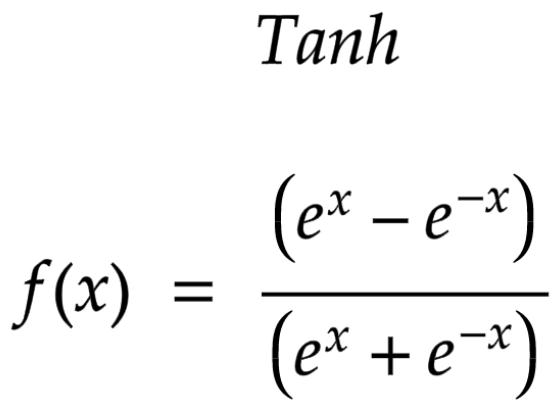

During back propagation of TanH activation, the gradients of TanH are calculated by calculating the derivative of TanH function.

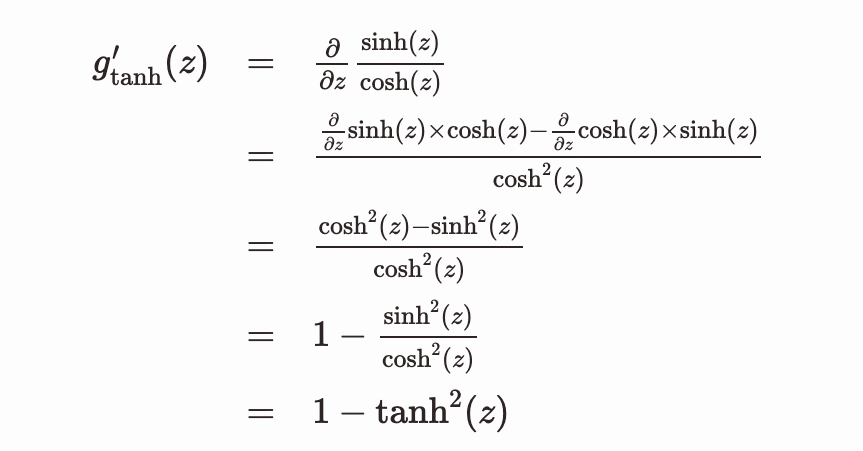

Calculating the gradient for TanH activation function uses the quotient rule.

The derivative of TanH is therefore, `1 - np.tanh(x) ** 2`, which has been implemented using `np.tanh` in the code cell below.

In [9]:
class TanH(Activation):
    def __init__(self):
        def tanh(x):
            return np.tanh(x)
        
        def tanh_prime(x):
            return 1 - np.tanh(x) ** 2
        
        super().__init__(tanh, tanh_prime)

### Softmax
The Softmax activation function is generally used as last layer in a Neural Network. Softmax converts the `Dense` layer's outputs to a probability map such that the sum of the outputs is equal to 1. Softmax is used in classification problems.

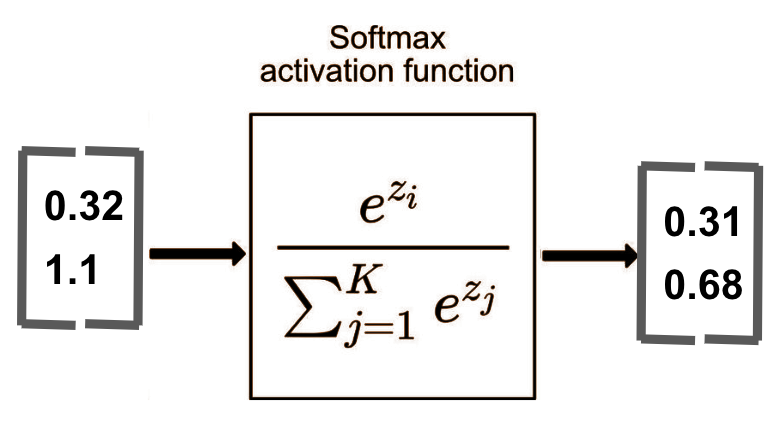

During back propagation, Softmax receives a gradient, i.e., the partial derivative of the loss with respect to its output values.

To use the Softmax function in Neural Networks, its derivative has to be computed. If $\Sigma_C$ is defined as, $\Sigma_C = \sum_{d=1}^C e^{z_d}, \text{for } c = 1 \cdots C$ so that $y_c = \frac{e^{z_c}}{\Sigma_C}$, then this derivative $frac{\partial y_i}{\partial z_j}$ of the output $y$ of the Softmax function with respect to its input $z$ can be calculated as,

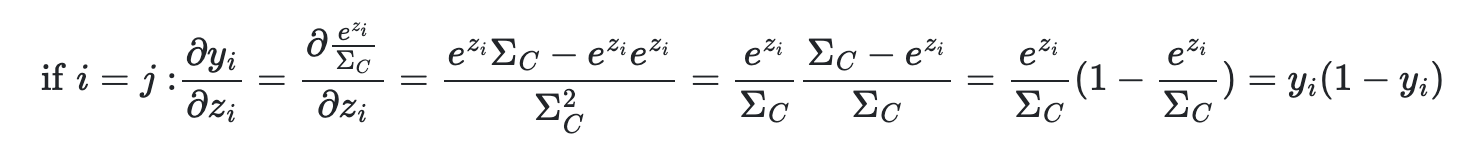

The first part of this expression propagates the Softmax values down the diagonal and then the product of Softmax values with respect to input are calculated.

In [10]:
class Softmax(Layer):
    def forward(self, input):
        tmp = np.exp(input)
        self.output = tmp/ np.sum(tmp)
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, output_gradient)

# `MaxPooling` Layer
The `MaxPooling` layer selects the maximum pixel values for every image in a particular Kernel area.

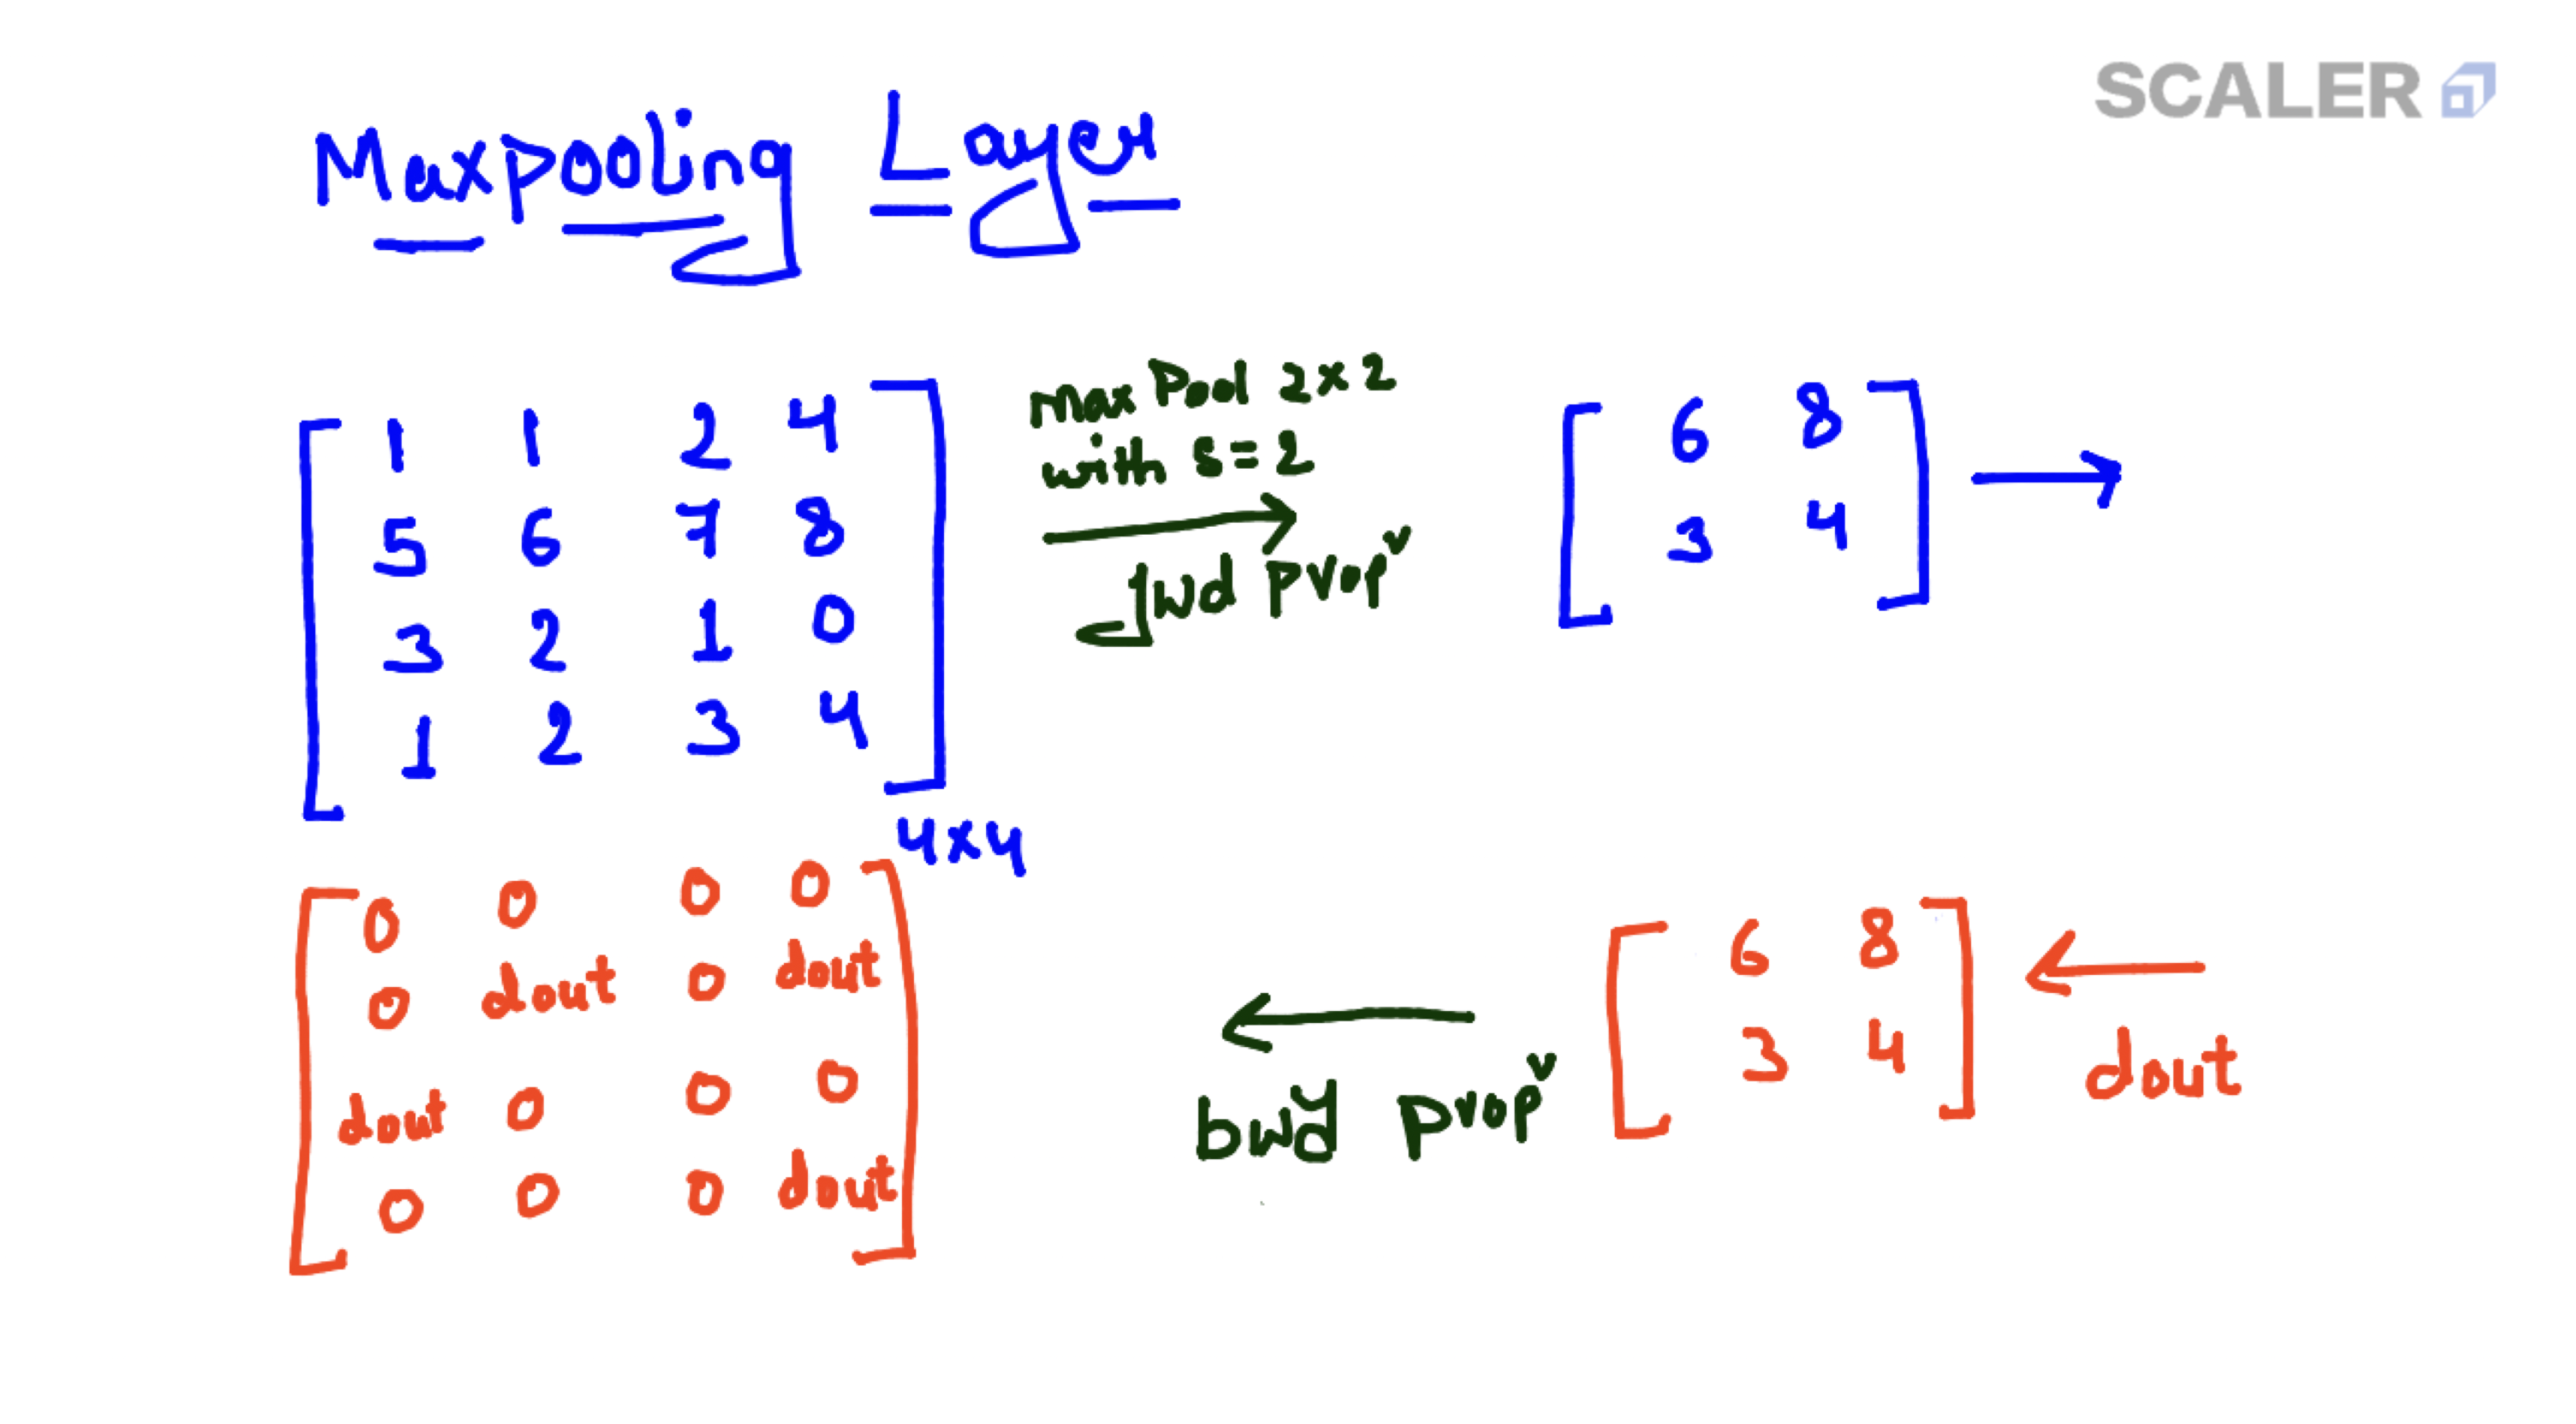

Forward propagation: A sliding window (typically `2 x 2`) moves across the input feature map. At each position, the maximum value within the window is selected and becomes the output for that region. The window then slides across the feature map according to the specified stride, creating a downsampled output feature map.

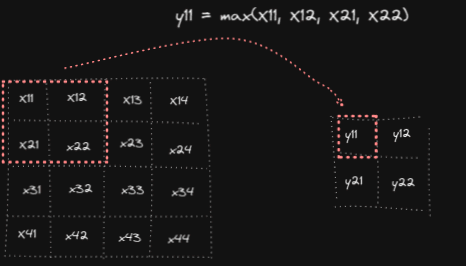

Back propagation: During back propagation through a `MaxPooling` layer, the gradient is passed back only to the input element that had the maximum value within the pooling window during the forward pass. All other input elements within that window receive 0 gradient. This effectively directs the gradient flow back to the most influential input, ensuring that the network learns to emphasizes the most important features.

In essence, the back propagation process in `MaxPooling` mirrors the forward pass, selectively passing the gradient back to the input element that contributed most to the output of the pooling operation.

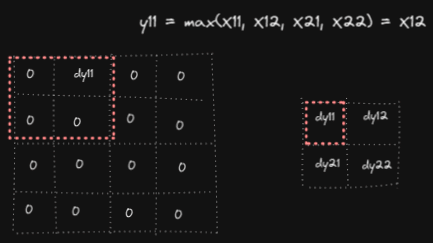

In [11]:
class MaxPool(Layer):
    def __init__(self, input_shape, kernel_size, depth, stride):
        # input_shape is 3 dimensional (d x h x w), input_depth = number of image input channels, input_height = image height, input_width = image width
        input_depth, input_height, input_width = input_shape
        # specify the shape of the input
        self.input_shape = input_shape
        # specify the Kernel size of the MaxPool operation
        self.kernel_size = kernel_size
        self.kernel_shape = (depth, input_depth, kernel_size, kernel_size)
        # specify the depth or number of Filters
        self.depth = depth
        # specify the depth or channels of the input
        self.input_depth = input_depth
        # initializing the kernel with random values of shape (kernel_shape)
        self.kernel = np.random.randn(*self.kernel_shape)
        self.stride = stride
        self.input_height, self.input_width = input_height, input_width

    def forward(self, input):
        self.input = input

        KH = 1 + (self.input_height - self.kernel_size)// self.stride
        KW = 1 + (self.input_width - self.kernel_size)// self.stride
        self.output = np.zeros((self.input_depth, KH, KW))

        for depth in range(self.input_depth):
            for r in range(0, self.input_height - 1, self.stride):
                for c in range(0, self.input_width - 1, self.stride):
                    self.output[depth, r// self.stride, c// self.stride] = np.max(self.input[depth, r: r + self.kernel_size, c: c + self.kernel_size])
        
        return self.output
    
    def backward(self, output_gradient, learning_rate):
        self.output_gradient = np.zeros(self.input_shape)
        # initialize gradient of the layer
        dx = np.zeros(self.input_shape)
        
        # the first for loop is to traverse through all the filters (depth)
        # the second for loop is to traverse through the height of the image
        # the third for loop is to traverse through the width of the image
        for depth in range(self.input_depth):
            for r in range(0, self.input_height - 1, self.stride):
                for c in range(0, self.input_width - 1, self.stride):
                    grad_pool = self.output[depth, r * self.stride: r * self.stride + self.kernel_size, c * self.stride: c * self.stride + self.kernel_size]
                    mask = (grad_pool == np.max(grad_pool))
                    dx[depth, r * self.stride: r * self.stride + self.kernel_size, c * self.stride : c * self.stride + self.kernel_size] = mask * self.output_gradient[depth, r, c]

        return dx

# `Reshape` Or Falttening Layer
This layer reshapes the arrays in order to pass them through the `Dense` layers. The `Reshape` layer is used to reshape the dimensions of an input array to a desired compatible shape using the `np.reshape` function.

An array of size `(5, 4, 1)` will be reshaped to a size of `(20, 1)` using `np.reshape`.

In [12]:
class Reshape(Layer):
    def __init__(self, input_shape, output_shape):
        # specifying the shape of input and output in the constructor
        self.input_shape = input_shape
        self.output_shape = output_shape

    def forward(self, input):
        # forward reshapes the input to the shape of output
        return np.reshape(input, self.output_shape)
    
    def backward(self, output_gradient, learning_rate):
        # backward reshapes the output to the shape of input
        return np.reshape(output_gradient, self.input_shape)

# `Dense` Layer
The `Dense` layer, also known as a fully connected layer, is a critical component in a CNN architecture. It serves to transform the high-dimensional feature maps generated by the `Convolutional` layers into a lower-dimensional feature vector. This dimensionality reduction not only improves computational efficiency but also helps prevent overfitting by simplifying the model. Each neuron in a `Dense` layer is connected to every neuron in the preceding layer, allowing for complex interactions between features. The layer typically applies a linear transformation to the input, followed by an activation function (like ReLU or softmax) to introduce non-linearity. This combination enables the network to effectively learn complex patterns and make accurate predictions on various tasks, including image classification, regression, and more.

$Z = W . X + B$. Where, $Z$ = Output matrix, $W$ = Weight matrix, $X$ = Input matrix, $B$ = Bias.

During back propagation in a `Dense` layer, the gradients of the loss function with respect to weights and biases are computed as follows,
1. Weights gradient: The gradient of the loss with respect to the weights is calculated by taking the dot product of the output gradient (the derivative of the loss with respect to the layer's output) and the transpose of the input to the layer.
2. Input gradient: The gradient of the loss with respect to the input to the layer is calculated by taking the dot product of the weights' transpose and the output gradient.
3. Weight update: The weights of the layer are updated using the calculated weights gradient and the learning rate. This update typically follows the gradient descent rule, where the weights are adjusted in the direction opposite to the gradient to minimize the loss.
4. Bias update: The bias of the layer is updated using the output gradient and the learning rate. Similar to the weight update, the bias is adjusted in the direction opposite to the gradient.

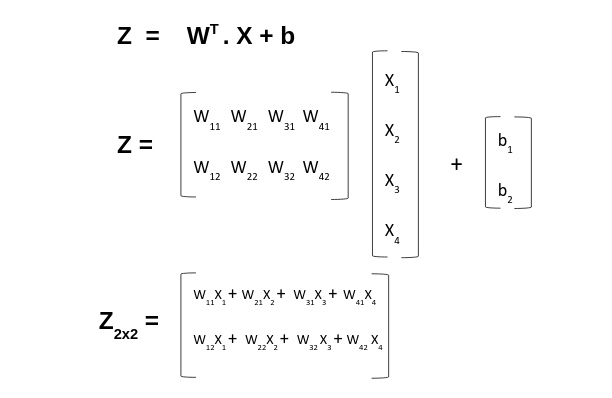

In [13]:
class Dense(Layer):
    def __init__(self, input_size, output_size):
        # defining the weights matrix shape
        self.weights = np.random.randn(output_size, input_size)
        # defining the m=bias matrix shape
        self.bias = np.random.randn(output_size, 1)

    def forward(self, input):
        self.input = input
        # implementing z = w.x + b
        return np.dot(self.weights, self.input) + self.bias
    
    def backward(self, output_gradient, learning_rate):
        # calculate weight gradient by dot product of output gradient and transpose of input
        weight_gradient = np.dot(output_gradient, self.input.T)
        # calculatw the input gradient by performing dot product of weights transpose and output gradient
        input_gradient = np.dot(self.weights.T, output_gradient)
        # update the weights of the layer with weight gradient with respect to the learning rate
        self.weights -= learning_rate * weight_gradient
        # update the bias of the layer with output gradient with respect to the learning rate
        self.bias -= learning_rate * output_gradient

        return input_gradient

# Defining Log-Loss
Log-Loss, also known as cross-entropy loss, is a common evaluation metric for probabilistic classification models. It measures the discrepancy between the predicted probabilities and the actual labels.

Log-Loss focuses on the predicted probabilities rather than just the class predictions. This makes it particularly useful for models that output probabilities, like Logistic Regression or Neural Networks.

Log-Loss depicts how close the prediction probability is to the corresponding true value. The further the predicted probability is from the true label (0 or 1), the higher will be the Log-Loss. This encourages the model to be more confident in its predictions.

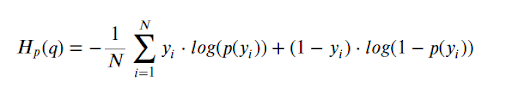

Log-Loss is calculated by taking the mean of the negative logarithm of the predicted probabilities for the correct class for each data point.

During back propagation through the network, the gradients of the network need to be calculated to update them. To calculate these gradients the derivative of Log-Loss with respect to the output is used to calculate the loss between the output and the actual labels.

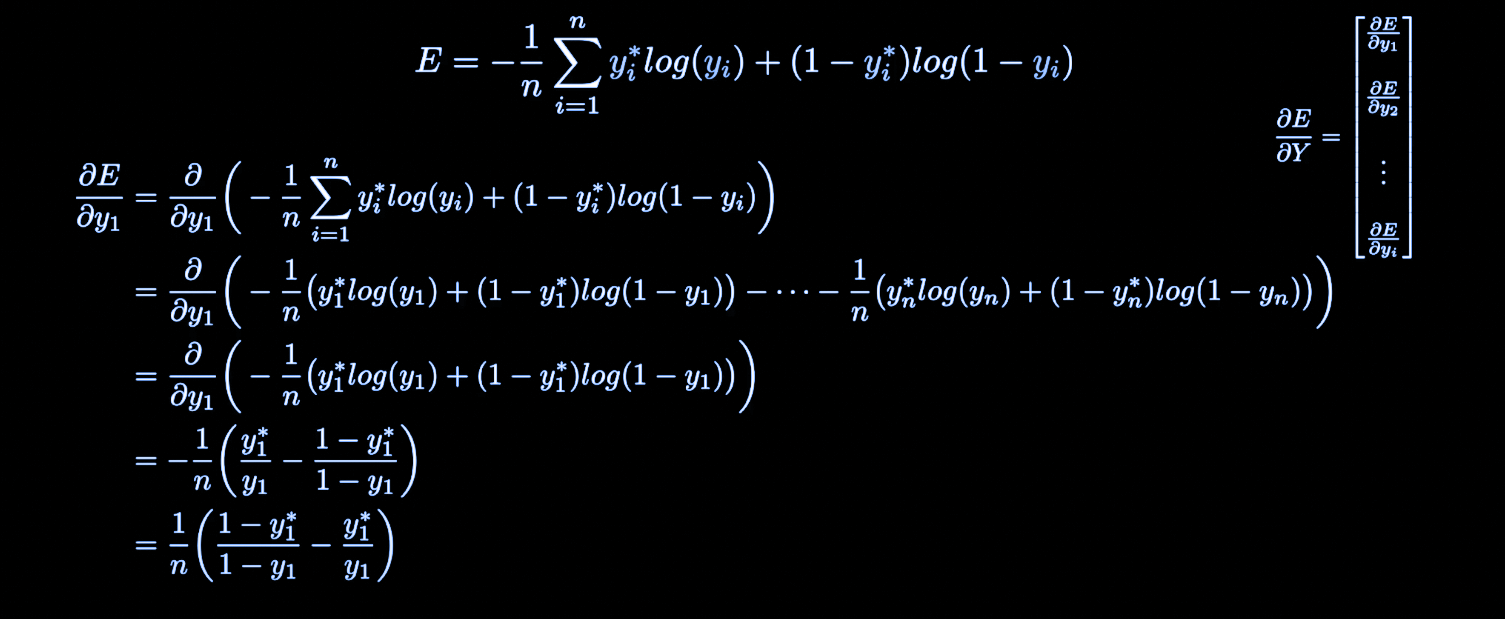

The derivative of Log-Loss is, $\frac{1}{N} * (\frac{(1 - y_{true})}{(1 - y_{pred})} - \frac{y_{true}}{y_{pred}})$.

The above has been coded as, `((1 - y_true)/ (1 - y_pred) - y_true / y_pred)/ np.size(y_true)`.

In [14]:
def log_loss(y_true, y_pred):
    return np.mean(- y_true * np.log(y_pred) - (1 - y_true) * np.log(1 - y_pred))

def log_loss_prime(y_true, y_pred):
    #log_loss_prime works the same way as log loss
    # but is the derivative of the above function which will be used to
    # compute layers gradients durin back propagation
    return ((1 - y_true)/ (1 - y_pred) - y_true/ y_pred) / np.size(y_true)

# Data Loading And Preprocessing

In [15]:
# loading the MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [16]:
# defining a method to preprocess the data
def preprocess_data(x, y, limit):
    # for the sake of simplicity only 10000 images from classes 0 and 1 are selected
    zero_index = np.where(y == 0)[0][: limit]
    one_index = np.where(y == 1)[0][: limit]
    all_indices = np.hstack((zero_index, one_index))
    all_indices = np.random.permutation(all_indices)
    x, y = x[all_indices], y[all_indices]
    # reshape to keep the first dimension the selected images only
    x = x.reshape(len(x), 1, 28, 28)
    # normalize all pixel values [0 - 1]
    # dividing by 255 because maximum possible pixel RGB value can be 255
    x = x.astype("float32")/ 255
    # one hot encode all the labels
    y = tf.keras.utils.to_categorical(y)
    y = y.reshape(len(y), 2, 1)
    return x, y

x_train, y_train = preprocess_data(x_train, y_train, 10000)
x_test, y_test = preprocess_data(x_test, y_test, 10000)

# Defining The Network Architecture
Network architecture is designed with a focus on inter-dimensional compatibility between layers, meticulously ensuring that the output shape of each layer precisely matches the input shape of the following layer.

In [17]:
network = [
    # input_size, kernel_size, depth
    Convolutional((1, 28, 28), 3, 5),
    ReLU(),
    # input_shape, kernel_size, depth, stride
    MaxPool((5, 26, 26), 2, 5, 1),
    # input_shape, output_shape
    Reshape((5, 25, 25), (5 * 25 * 25, 1)),
    # input_size, output_size
    Dense(5 * 25 * 25, 100),
    TanH(),
    # input_size, output_size
    Dense(100, 2),
    Softmax()
]

# Training The Network

In [18]:
def train(network, loss, loss_prime, x_train, y_train, epochs = 10, learning_rate = 0.01):
    for e in range(epochs):
        error = 0
        idx = 0
        for x, y in zip(x_train, y_train):
            # print the progress
            if (idx + 1) % 100 == 0:
                print(f"Epoch {e}: {idx + 1}/ {len(y_train)}")

            idx += 1

            # forward pass to predict on the training data
            output = predict(network, x)

            # summing the losses to optimize the network's weights and biases
            error += loss(y, output)

            # performing backward pass through every layer by computing the gradients
            grad = loss_prime(y, output)
            for layer in reversed(network):
                grad = layer.backward(grad, learning_rate)

        error /= len(x_train)
        print(f"Epoch: {e + 1}/ {epochs}, loss = {error}")

# defining a method to predict using the NN
def predict(network, input):
    output = input
    
    # performing a forward pass to the network
    for layer in network:
        output = layer.forward(output)

    return output

In [19]:
# training the model
train(network, log_loss, log_loss_prime, x_train, y_train, epochs = 10, learning_rate = 0.0001)

Epoch 0: 100/ 12665
Epoch 0: 200/ 12665
Epoch 0: 300/ 12665
Epoch 0: 400/ 12665
Epoch 0: 500/ 12665
Epoch 0: 600/ 12665
Epoch 0: 700/ 12665
Epoch 0: 800/ 12665
Epoch 0: 900/ 12665
Epoch 0: 1000/ 12665
Epoch 0: 1100/ 12665
Epoch 0: 1200/ 12665
Epoch 0: 1300/ 12665
Epoch 0: 1400/ 12665
Epoch 0: 1500/ 12665
Epoch 0: 1600/ 12665
Epoch 0: 1700/ 12665
Epoch 0: 1800/ 12665
Epoch 0: 1900/ 12665
Epoch 0: 2000/ 12665
Epoch 0: 2100/ 12665
Epoch 0: 2200/ 12665
Epoch 0: 2300/ 12665
Epoch 0: 2400/ 12665
Epoch 0: 2500/ 12665
Epoch 0: 2600/ 12665
Epoch 0: 2700/ 12665
Epoch 0: 2800/ 12665
Epoch 0: 2900/ 12665
Epoch 0: 3000/ 12665
Epoch 0: 3100/ 12665
Epoch 0: 3200/ 12665
Epoch 0: 3300/ 12665
Epoch 0: 3400/ 12665
Epoch 0: 3500/ 12665
Epoch 0: 3600/ 12665
Epoch 0: 3700/ 12665
Epoch 0: 3800/ 12665
Epoch 0: 3900/ 12665
Epoch 0: 4000/ 12665
Epoch 0: 4100/ 12665
Epoch 0: 4200/ 12665
Epoch 0: 4300/ 12665
Epoch 0: 4400/ 12665
Epoch 0: 4500/ 12665
Epoch 0: 4600/ 12665
Epoch 0: 4700/ 12665
Epoch 0: 4800/ 12665
E

# Evaluating On Test Data
The `predict` method takes an image input and then performs forward propagation through every layer in the network inorder to make a prediction.

In [20]:
len(x_test)

2115

In [21]:
# calculate the accuracy of the network
correct = 0
for x, y in zip(x_test, y_test):
    output = predict(network, x)

    # check if the predicted label is equal to the true label
    if np.equal(np.argmax(output), np.argmax(y)):
        correct += 1

print(f"Accuracy of the network on test data = {(correct/ len(x_test)) * 100}%")

Accuracy of the network on test data = 98.72340425531915%


# Random Sample Testing
To evaluate the model, the outputs and the predictions must be visualized to get a better understanding of the data and model's performance.

In [22]:
import random

def test_random_sample():
    sample_index = random.randint(0, 100)
    x_sample, y_sample = x_test[sample_index], y_test[sample_index]
    output = predict(network, x_sample)
    x_sample = np.squeeze(x_sample, axis = 0)
    plt.rcParams["figure.figsize"] = [2, 2]
    plt.imshow(x_sample)
    plt.axis("off")
    print(f"Predicting on image sample {sample_index} from test data")
    print(f"Prediction: {np.argmax(output)}")
    print(f"Actual: {np.argmax(y_sample)}")

Predicting on image sample 14 from test data
Prediction: 1
Actual: 1


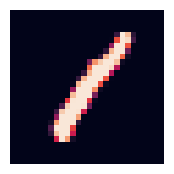

In [23]:
test_random_sample()

Predicting on image sample 44 from test data
Prediction: 1
Actual: 1


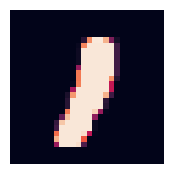

In [24]:
test_random_sample()

Predicting on image sample 71 from test data
Prediction: 0
Actual: 0


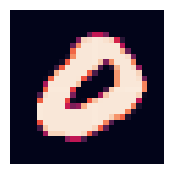

In [25]:
test_random_sample()

Predicting on image sample 21 from test data
Prediction: 0
Actual: 0


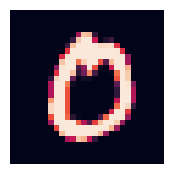

In [26]:
test_random_sample()

# Visualizing Layer Outputs
To get a better understanding of what each layer does to the input image and what its individual output looks like a method is created to pass a random test image through the trained network and the image is plotted as it passes through the different layers of the network.

In [27]:
def layer_outputs(network, input):
    # initialize the output
    output = input

    # initialize the layer number
    layer_n = 0

    # iterate through layers in the network
    for layer in network:
        if layer_n <= 3:
            plt.imshow(output[0, :, :])
            plt.axis("off")

        # compute the output of the current layer
        output = layer.forward(output)
        # increment the layer number
        layer_n = layer_n + 1
        plt.show()

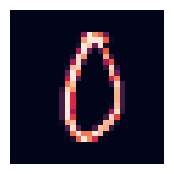

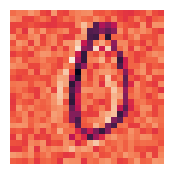

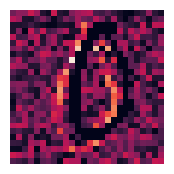

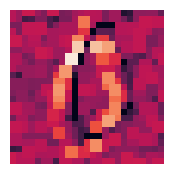

In [28]:
# plotting the displaying layer outputs in the order, input image -> Convolutional output -> ReLU output -> MaxPool output
sample_index = random.randint(0, len(x_test))
x_sample, y_sample = x_test[sample_index], y_test[sample_index]
layer_outputs(network, x_sample)

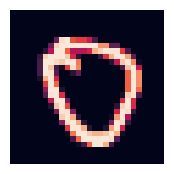

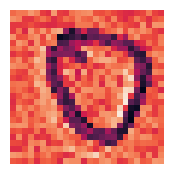

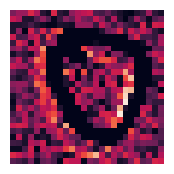

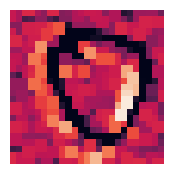

In [29]:
sample_index = random.randint(0, len(x_test))
x_sample, y_sample = x_test[sample_index], y_test[sample_index]
layer_outputs(network, x_sample)

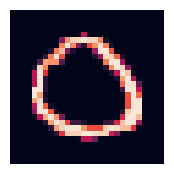

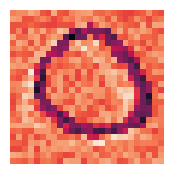

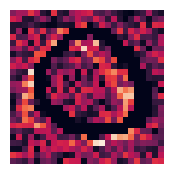

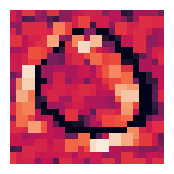

In [30]:
sample_index = random.randint(0, len(x_test))
x_sample, y_sample = x_test[sample_index], y_test[sample_index]
layer_outputs(network, x_sample)

# Layer Output Dimensions
A method is created to visualize the changes in dimensions of the input image as it passes through each layer.

In [31]:
def layer_shape(network, input):
    output = input

    # perform a forward pass
    for layer in network:
        # pass the image to every layer's forward method
        output = layer.forward(output)

        # print the layer name
        print(layer)

        # print the layer shape
        print(output.shape)

    # returning the index in the output class probabilities with the highest value to get the class label
    return output.argmax()

In [32]:
print(np.argmax(y_sample))
layer_shape(network, x_sample)

0
(5, 26, 26)
(5, 26, 26)
(5, 25, 25)
(3125, 1)
(100, 1)
(100, 1)
(2, 1)
(2, 1)


0